In [1]:
import csv
import sys
import glob, os
import copy
import gc
from tqdm import tqdm
import time
import math
from PIL import Image
import cv2
from shapely.geometry import MultiPolygon, Polygon, Point
import shapely.wkt
import shapely.affinity
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.plot import show
import rasterio.mask
import gdal
import ogr
import numpy as np
import random
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import itertools
import psutil
sys.setrecursionlimit(10**6)
from skimage import morphology
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Subset
#from torchsummary import summary
#import segmentation_models_pytorch as smp
#from segmentation_models_pytorch.encoders import get_preprocessing_fn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import albumentations as albu

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [3]:
#  get data list
path_3band = '../building_detection_data/3band_train/3band/'
path_8band = '../building_detection_data/8band_train/8band/'
path_3band_test = '../building_detection_data/3band_test/'
path_8band_test = '../building_detection_data/8band_test/'
path_geojson = '../building_detection_data/geojson_train/'
path_mask_img = '../building_detection_data/MaskImages/'

def get_list(path):
    return [f for f in os.listdir(path) if not f.startswith('.')]

list_3band = get_list(path_3band)
list_8band = get_list(path_8band)
list_geojson = get_list(path_geojson)

list_3band_test = get_list(path_3band_test)
list_8band_test = get_list(path_8band_test)

(448, 448, 3)


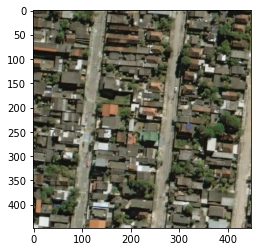

In [4]:
img = rio.open('../building_detection_data/3band_train/3band/3band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(448, 448), resampling=Resampling.bilinear)

data = data.transpose(1,2,0)
if data.max()!= 0:
    data = data / data.max()
print(data.shape)
img = np.array(data)
plt.imshow(img)

In [5]:
img = rio.open('../building_detection_data/3band_train/3band/3band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
img = np.array(data)
img[:,:,0].max()

242

(224, 224, 3)


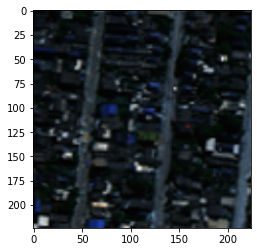

In [6]:
img = rio.open('../building_detection_data/8band_train/8band/8band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
data = np.stack([data[:,:,1], data[:,:,2], data[:,:,4]], axis=2)
if data.max()!= 0:
    data = data / data.max()
print(data.shape)
img = np.array(data)
plt.imshow(img)

In [7]:
img = rio.open('../building_detection_data/8band_train/8band/8band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
img = np.array(data)
img[:,:,6].max()

6265

In [8]:
import os
print(os.listdir("../building_detection_data/3band_train/3band"))

['3band_AOI_1_RIO_img1.tif', '3band_AOI_1_RIO_img10.tif', '3band_AOI_1_RIO_img100.tif', '3band_AOI_1_RIO_img1000.tif', '3band_AOI_1_RIO_img1001.tif', '3band_AOI_1_RIO_img1002.tif', '3band_AOI_1_RIO_img1003.tif', '3band_AOI_1_RIO_img1004.tif', '3band_AOI_1_RIO_img1005.tif', '3band_AOI_1_RIO_img1006.tif', '3band_AOI_1_RIO_img1007.tif', '3band_AOI_1_RIO_img1008.tif', '3band_AOI_1_RIO_img1009.tif', '3band_AOI_1_RIO_img101.tif', '3band_AOI_1_RIO_img1010.tif', '3band_AOI_1_RIO_img1011.tif', '3band_AOI_1_RIO_img1012.tif', '3band_AOI_1_RIO_img1013.tif', '3band_AOI_1_RIO_img1014.tif', '3band_AOI_1_RIO_img1015.tif', '3band_AOI_1_RIO_img1016.tif', '3band_AOI_1_RIO_img1017.tif', '3band_AOI_1_RIO_img3730.tif', '3band_AOI_1_RIO_img3731.tif', '3band_AOI_1_RIO_img3732.tif', '3band_AOI_1_RIO_img3733.tif', '3band_AOI_1_RIO_img3734.tif', '3band_AOI_1_RIO_img3735.tif', '3band_AOI_1_RIO_img3736.tif', '3band_AOI_1_RIO_img3737.tif', '3band_AOI_1_RIO_img3738.tif', '3band_AOI_1_RIO_img3739.tif', '3band_AOI_1_R

In [9]:
import os
print(os.listdir("../building_detection_data/8band_train/8band"))

['8band_AOI_1_RIO_img1.tif', '8band_AOI_1_RIO_img10.tif', '8band_AOI_1_RIO_img100.tif', '8band_AOI_1_RIO_img1000.tif', '8band_AOI_1_RIO_img1001.tif', '8band_AOI_1_RIO_img1002.tif', '8band_AOI_1_RIO_img1003.tif', '8band_AOI_1_RIO_img1004.tif', '8band_AOI_1_RIO_img1005.tif', '8band_AOI_1_RIO_img1006.tif', '8band_AOI_1_RIO_img1007.tif', '8band_AOI_1_RIO_img1008.tif', '8band_AOI_1_RIO_img1009.tif', '8band_AOI_1_RIO_img101.tif', '8band_AOI_1_RIO_img1010.tif', '8band_AOI_1_RIO_img4270.tif', '8band_AOI_1_RIO_img4271.tif', '8band_AOI_1_RIO_img4272.tif', '8band_AOI_1_RIO_img4273.tif', '8band_AOI_1_RIO_img4274.tif', '8band_AOI_1_RIO_img4275.tif', '8band_AOI_1_RIO_img4276.tif', '8band_AOI_1_RIO_img4277.tif', '8band_AOI_1_RIO_img4278.tif', '8band_AOI_1_RIO_img4279.tif', '8band_AOI_1_RIO_img428.tif', '8band_AOI_1_RIO_img4280.tif', '8band_AOI_1_RIO_img4281.tif', '8band_AOI_1_RIO_img4282.tif', '8band_AOI_1_RIO_img4283.tif', '8band_AOI_1_RIO_img4284.tif', '8band_AOI_1_RIO_img3155.tif', '8band_AOI_1_RI

In [10]:
import os
print(os.listdir("../building_detection_data/MaskImages"))

['AOI_1_RIO_img1.tif', 'AOI_1_RIO_img10.tif', 'AOI_1_RIO_img100.tif', 'AOI_1_RIO_img1000.tif', 'AOI_1_RIO_img1001.tif', 'AOI_1_RIO_img1002.tif', 'AOI_1_RIO_img1003.tif', 'AOI_1_RIO_img1004.tif', 'AOI_1_RIO_img1005.tif', 'AOI_1_RIO_img1006.tif', 'AOI_1_RIO_img1007.tif', 'AOI_1_RIO_img1008.tif', 'AOI_1_RIO_img1009.tif', 'AOI_1_RIO_img101.tif', 'AOI_1_RIO_img1010.tif', 'AOI_1_RIO_img1011.tif', 'AOI_1_RIO_img1012.tif', 'AOI_1_RIO_img1013.tif', 'AOI_1_RIO_img1014.tif', 'AOI_1_RIO_img1015.tif', 'AOI_1_RIO_img1016.tif', 'AOI_1_RIO_img1017.tif', 'AOI_1_RIO_img1018.tif', 'AOI_1_RIO_img1019.tif', 'AOI_1_RIO_img2530.tif', 'AOI_1_RIO_img2531.tif', 'AOI_1_RIO_img2532.tif', 'AOI_1_RIO_img2533.tif', 'AOI_1_RIO_img2534.tif', 'AOI_1_RIO_img2535.tif', 'AOI_1_RIO_img2536.tif', 'AOI_1_RIO_img2537.tif', 'AOI_1_RIO_img2538.tif', 'AOI_1_RIO_img2539.tif', 'AOI_1_RIO_img254.tif', 'AOI_1_RIO_img2540.tif', 'AOI_1_RIO_img2541.tif', 'AOI_1_RIO_img2542.tif', 'AOI_1_RIO_img2543.tif', 'AOI_1_RIO_img4130.tif', 'AOI_1_

In [11]:
import os
print(os.listdir('../building_detection_data/3band_test/'))

['3band_AOI_2_RIO_img1.tif', '3band_AOI_2_RIO_img10.tif', '3band_AOI_2_RIO_img100.tif', '3band_AOI_2_RIO_img1000.tif', '3band_AOI_2_RIO_img1001.tif', '3band_AOI_2_RIO_img1002.tif', '3band_AOI_2_RIO_img1003.tif', '3band_AOI_2_RIO_img1004.tif', '3band_AOI_2_RIO_img1005.tif', '3band_AOI_2_RIO_img1006.tif', '3band_AOI_2_RIO_img1007.tif', '3band_AOI_2_RIO_img1008.tif', '3band_AOI_2_RIO_img1009.tif', '3band_AOI_2_RIO_img101.tif', '3band_AOI_2_RIO_img1010.tif', '3band_AOI_2_RIO_img1011.tif', '3band_AOI_2_RIO_img1012.tif', '3band_AOI_2_RIO_img1013.tif', '3band_AOI_2_RIO_img1014.tif', '3band_AOI_2_RIO_img1015.tif', '3band_AOI_2_RIO_img1016.tif', '3band_AOI_2_RIO_img1017.tif', '3band_AOI_2_RIO_img1018.tif', '3band_AOI_2_RIO_img1019.tif', '3band_AOI_2_RIO_img102.tif', '3band_AOI_2_RIO_img1020.tif', '3band_AOI_2_RIO_img1021.tif', '3band_AOI_2_RIO_img1022.tif', '3band_AOI_2_RIO_img1023.tif', '3band_AOI_2_RIO_img2535.tif', '3band_AOI_2_RIO_img2536.tif', '3band_AOI_2_RIO_img2537.tif', '3band_AOI_2_RI

In [12]:
import os
print(os.listdir('../building_detection_data/8band_test/'))

['8band_AOI_2_RIO_img1.tif', '8band_AOI_2_RIO_img10.tif', '8band_AOI_2_RIO_img100.tif', '8band_AOI_2_RIO_img1000.tif', '8band_AOI_2_RIO_img1001.tif', '8band_AOI_2_RIO_img1002.tif', '8band_AOI_2_RIO_img1003.tif', '8band_AOI_2_RIO_img1004.tif', '8band_AOI_2_RIO_img1005.tif', '8band_AOI_2_RIO_img1006.tif', '8band_AOI_2_RIO_img1007.tif', '8band_AOI_2_RIO_img1008.tif', '8band_AOI_2_RIO_img1009.tif', '8band_AOI_2_RIO_img101.tif', '8band_AOI_2_RIO_img1010.tif', '8band_AOI_2_RIO_img1011.tif', '8band_AOI_2_RIO_img1012.tif', '8band_AOI_2_RIO_img1013.tif', '8band_AOI_2_RIO_img1014.tif', '8band_AOI_2_RIO_img1015.tif', '8band_AOI_2_RIO_img1016.tif', '8band_AOI_2_RIO_img1017.tif', '8band_AOI_2_RIO_img1018.tif', '8band_AOI_2_RIO_img1019.tif', '8band_AOI_2_RIO_img102.tif', '8band_AOI_2_RIO_img2123.tif', '8band_AOI_2_RIO_img2124.tif', '8band_AOI_2_RIO_img2125.tif', '8band_AOI_2_RIO_img2126.tif', '8band_AOI_2_RIO_img2127.tif', '8band_AOI_2_RIO_img2128.tif', '8band_AOI_2_RIO_img2129.tif', '8band_AOI_2_RI

In [13]:
import os
print(len(os.listdir("../building_detection_data/3band_train/3band")))
print(len(os.listdir("../building_detection_data/8band_train/8band")))
print(len(os.listdir("../building_detection_data/MaskImages")))
print(len(os.listdir("../building_detection_data/3band_test")))
print(len(os.listdir("../building_detection_data/8band_test")))

6940
6940
6940
2795
2795


(406, 439, 1)


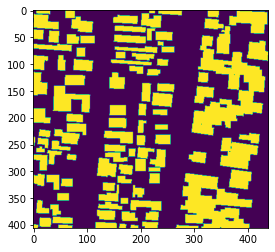

In [14]:
mask = rio.open('../building_detection_data/MaskImages/AOI_1_RIO_img3745.tif')
data = mask.read()
data = data.transpose(1,2,0)
print(data.shape)
mask = np.array(data)
plt.imshow(mask)

create mask images

In [15]:
def create_poly_mask(rasterSrc, vectorSrc, npDistFileName=''):

    # load vector
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

	# load raster
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize
        
    dstPath = npDistFileName

	# create mask img
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte)
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[255], options=['COMPRESS=LZW'])
    dst_ds = 0
    
    mask_image = Image.open(dstPath)
    mask_image = np.array(mask_image)
    
    return mask_image


def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
    os.makedirs(dst_dir, exist_ok=True)

    file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

    print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

    for idx in tqdm(range(1, file_count + 1)):

        src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
        src_vector_filename = "Geo_AOI_1_RIO_img{}.geojson".format(idx)
        dst_filename = "AOI_1_RIO_img{}.tif".format(idx)

        src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
        src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
        dst_path = os.path.join(dst_dir, dst_filename)

        create_poly_mask(
            src_raster_path, src_vector_path, npDistFileName=dst_path
        )

In [16]:
#build_labels(path_3band, path_geojson, path_mask_img)

In [17]:
list_masks = get_list(path_mask_img)

list_3band = sorted(list_3band)
list_8band = sorted(list_8band)
list_3band_test = sorted(list_3band_test)
list_8band_test = sorted(list_8band_test)
list_masks = sorted(list_masks)

In [18]:
N = len(list_3band)

import random
rand_list = random.sample(range(N), k=N//2)
rand_list = sorted(rand_list)

# to prevent the memories overhead
_list_3band = []
_list_8band = []
_list_masks = []

for i in range(N//2):
    _list_3band.append(list_3band[rand_list[i]])
    _list_8band.append(list_8band[rand_list[i]])
    _list_masks.append(list_masks[rand_list[i]])

In [19]:
import random
test_data_num = N//2//5 # about 1/5 of the number of train data

N_test = len(list_3band_test)
rand_list = random.sample(range(N_test), k=test_data_num)
rand_list = sorted(rand_list)

_list_3band_test = []
_list_8band_test = []

for i in range(test_data_num):
    _list_3band_test.append(list_3band_test[rand_list[i]])
    _list_8band_test.append(list_8band_test[rand_list[i]])

In [20]:
len(_list_3band), _list_3band

(3470,
 ['3band_AOI_1_RIO_img1.tif',
  '3band_AOI_1_RIO_img100.tif',
  '3band_AOI_1_RIO_img1000.tif',
  '3band_AOI_1_RIO_img1004.tif',
  '3band_AOI_1_RIO_img1005.tif',
  '3band_AOI_1_RIO_img1007.tif',
  '3band_AOI_1_RIO_img1008.tif',
  '3band_AOI_1_RIO_img1009.tif',
  '3band_AOI_1_RIO_img101.tif',
  '3band_AOI_1_RIO_img1010.tif',
  '3band_AOI_1_RIO_img1012.tif',
  '3band_AOI_1_RIO_img1014.tif',
  '3band_AOI_1_RIO_img1016.tif',
  '3band_AOI_1_RIO_img1017.tif',
  '3band_AOI_1_RIO_img1018.tif',
  '3band_AOI_1_RIO_img102.tif',
  '3band_AOI_1_RIO_img1020.tif',
  '3band_AOI_1_RIO_img1025.tif',
  '3band_AOI_1_RIO_img1026.tif',
  '3band_AOI_1_RIO_img1028.tif',
  '3band_AOI_1_RIO_img103.tif',
  '3band_AOI_1_RIO_img1031.tif',
  '3band_AOI_1_RIO_img1032.tif',
  '3band_AOI_1_RIO_img1034.tif',
  '3band_AOI_1_RIO_img1035.tif',
  '3band_AOI_1_RIO_img104.tif',
  '3band_AOI_1_RIO_img1043.tif',
  '3band_AOI_1_RIO_img1048.tif',
  '3band_AOI_1_RIO_img1049.tif',
  '3band_AOI_1_RIO_img1051.tif',
  '3band_AO

In [21]:
len(_list_8band), _list_8band

(3470,
 ['8band_AOI_1_RIO_img1.tif',
  '8band_AOI_1_RIO_img100.tif',
  '8band_AOI_1_RIO_img1000.tif',
  '8band_AOI_1_RIO_img1004.tif',
  '8band_AOI_1_RIO_img1005.tif',
  '8band_AOI_1_RIO_img1007.tif',
  '8band_AOI_1_RIO_img1008.tif',
  '8band_AOI_1_RIO_img1009.tif',
  '8band_AOI_1_RIO_img101.tif',
  '8band_AOI_1_RIO_img1010.tif',
  '8band_AOI_1_RIO_img1012.tif',
  '8band_AOI_1_RIO_img1014.tif',
  '8band_AOI_1_RIO_img1016.tif',
  '8band_AOI_1_RIO_img1017.tif',
  '8band_AOI_1_RIO_img1018.tif',
  '8band_AOI_1_RIO_img102.tif',
  '8band_AOI_1_RIO_img1020.tif',
  '8band_AOI_1_RIO_img1025.tif',
  '8band_AOI_1_RIO_img1026.tif',
  '8band_AOI_1_RIO_img1028.tif',
  '8band_AOI_1_RIO_img103.tif',
  '8band_AOI_1_RIO_img1031.tif',
  '8band_AOI_1_RIO_img1032.tif',
  '8band_AOI_1_RIO_img1034.tif',
  '8band_AOI_1_RIO_img1035.tif',
  '8band_AOI_1_RIO_img104.tif',
  '8band_AOI_1_RIO_img1043.tif',
  '8band_AOI_1_RIO_img1048.tif',
  '8band_AOI_1_RIO_img1049.tif',
  '8band_AOI_1_RIO_img1051.tif',
  '8band_AO

In [22]:
len(_list_masks), _list_masks

(3470,
 ['AOI_1_RIO_img1.tif',
  'AOI_1_RIO_img100.tif',
  'AOI_1_RIO_img1000.tif',
  'AOI_1_RIO_img1004.tif',
  'AOI_1_RIO_img1005.tif',
  'AOI_1_RIO_img1007.tif',
  'AOI_1_RIO_img1008.tif',
  'AOI_1_RIO_img1009.tif',
  'AOI_1_RIO_img101.tif',
  'AOI_1_RIO_img1010.tif',
  'AOI_1_RIO_img1012.tif',
  'AOI_1_RIO_img1014.tif',
  'AOI_1_RIO_img1016.tif',
  'AOI_1_RIO_img1017.tif',
  'AOI_1_RIO_img1018.tif',
  'AOI_1_RIO_img102.tif',
  'AOI_1_RIO_img1020.tif',
  'AOI_1_RIO_img1025.tif',
  'AOI_1_RIO_img1026.tif',
  'AOI_1_RIO_img1028.tif',
  'AOI_1_RIO_img103.tif',
  'AOI_1_RIO_img1031.tif',
  'AOI_1_RIO_img1032.tif',
  'AOI_1_RIO_img1034.tif',
  'AOI_1_RIO_img1035.tif',
  'AOI_1_RIO_img104.tif',
  'AOI_1_RIO_img1043.tif',
  'AOI_1_RIO_img1048.tif',
  'AOI_1_RIO_img1049.tif',
  'AOI_1_RIO_img1051.tif',
  'AOI_1_RIO_img1052.tif',
  'AOI_1_RIO_img1053.tif',
  'AOI_1_RIO_img1054.tif',
  'AOI_1_RIO_img1055.tif',
  'AOI_1_RIO_img1056.tif',
  'AOI_1_RIO_img1057.tif',
  'AOI_1_RIO_img106.tif',
  '

In [23]:
#  resize images
s = 224
N = len(list_3band)

def standardize(img):
    mean = img.mean()
    std = img.std()
    if(std != 0):
        img = (img - mean) / std
    return img    

def resize_images(list, path):
    images = []
    for i in tqdm(list):
        im = rio.open(path + i)
        im = im.read(out_shape=(s,s), resampling=Resampling.bilinear)
        if im.max()!=0:
            im = im / im.max()
        #im = standardize(im)
        images.append(im)
    return images

# # added by yoshioka 2021/06/05
# def resize_images_8band_to_4band(list, path):
#     images = []
#     for i in tqdm(list):
#         im = rio.open(path+i)
#         im = im.read(out_shape=(s,s), resampling=Resampling.bilinear)
#         if im.max()!=0:
#             im = im / im.max()
#         im = np.stack([im[1,:,:], im[2,:,:], im[4,:,:], im[6,:,:]], axis=0)
#         images.append(im)
#     return images

# added by yoshioka 2021/06/05
def resize_images_make_4band(list_3band, list_8band, three_band_path, eight_band_path):
    images = []
    for i, j in tqdm(zip(list_3band, list_8band)):
        im_3band = rio.open(three_band_path+i)
        im_8band = rio.open(eight_band_path+j)
        im_3band = im_3band.read(out_shape=(s,s), resampling=Resampling.bilinear)
        im_8band = im_8band.read(out_shape=(s,s), resampling=Resampling.bilinear)
        
        im_3band = np.array(im_3band)
        im_3band = im_3band / im_3band.max()
        
        im_8band = np.array(im_8band)
        im_8band = im_8band / im_8band.max()
        
        im_cat = np.stack([im_3band[0,:,:], im_3band[1,:,:], im_3band[2,:,:], im_8band[6,:,:]], axis=0)
        # --------------warning-----------------
        # The following normalization causes the images to be very dark!!
        if im_cat.max()!=0:
            im_cat = im_cat / im_cat.max()

        # im_cat = standardize(im_cat) # -> it causes wrong result
        images.append(im_cat)
    return images

# revised by yoshioka 2021/06/05
# to change the 3 band images to 4 band images
# by adding NIR in 8 band images
def get_batch_imgs(b, lists=[list_3band, list_8band], paths=[path_3band, path_8band]):
    out = np.zeros((N, b, s, s))
    if b == 8:
        for i, img in tqdm(enumerate(resize_images(lists[1], paths[1]))):
            out[i,:,:,:] = img
    elif b == 3:
        for i, img in tqdm(enumerate(resize_images(lists[0], paths[0]))):
            out[i,:,:,:] = img
    elif b == 4:
        for i, img in tqdm(enumerate(resize_images_make_4band(lists[0], lists[1], paths[0], paths[1]))):
            out[i,:,:,:] = img
    else:
        print("ERROR IN BAND NUMBER!")
    return out

def get_batch_masks(list, path):
    out = np.zeros((N, s, s))
    for i, img in tqdm(enumerate(resize_images(list, path))):
        out[i,:,:] = img
    return out

# def concat_band(list3, list8):
#     out = np.zeros((N, 11, s, s))
#     for i, (j, k) in tqdm(enumerate(zip(list3, list8))):
#         im = np.concatenate([j,k],0)
#         out[i,:,:,:] = im
#     return out

In [24]:
im = rio.open('../building_detection_data/8band/8band_AOI_2_RIO_img1015.tif').read().astype('float32')
print(im.shape)
im = np.stack([im[1,:,:], im[2,:,:]], axis=0)
print(im.shape)

(8, 102, 110)
(2, 102, 110)


In [25]:
val_r = 0.05

def split(data, r):
    train, test = train_test_split(data, test_size=r, random_state=0)
    return train, test

_list_3band, _list_8bandを用いると, 全データのうち1/10がbatchに入るが, それ以外の9/10が0埋め（全要素が0の3次元配列）されてしまう  
-> 単純な解決策として, 0埋めされた9/10を後で排除（以下は例）  
zero_indices = []  
for i in range(6940):  
    if list_np_3band[i].max() == 0:  
        zero_indices.append(i)  
np.delete(list_np_3band, zero_indices, axis=0)  

In [26]:
# make 4band and 8band
# 4band -> 3band(RGB) + NIR in 8band # index 6(0 origin)
list_np_4band = get_batch_imgs(b=4, lists=[_list_3band, _list_8band], paths=[path_3band, path_8band]).astype(np.float32)

#list_np_8band = get_batch_imgs(b=8, lists=[_list_3band, _list_8band], paths=[path_3band, path_8band]).astype(np.float32)

3470it [04:22, 13.24it/s]
3470it [00:02, 1594.17it/s]


In [27]:
zero_indices = []  
for i in range(6940):  
    if list_np_4band[i].max() == 0:  
        zero_indices.append(i)  
list_np_4band = np.delete(list_np_4band, zero_indices, axis=0)  

Somehow, a batch is created with the number before the reduction (=6940).

In [28]:
list_np_4band.shape

(3470, 4, 224, 224)

In [29]:
import gc
train_4b_img, val_4b_img = split(list_np_4band, val_r)
del list_np_4band
gc.collect()

59

In [30]:
train_4b_img.shape, val_4b_img.shape

((3296, 4, 224, 224), (174, 4, 224, 224))

omit 8band data because its data size is large

In [31]:
#list_np_8band = get_batch_imgs(b=8, lists=[_list_3band, _list_8band], paths=[path_3band, path_8band]).astype(np.float32)

In [32]:
# import gc
#train_8b_img, val_8b_img = split(list_np_8band, val_r)
# del list_np_8band
# gc.collect()

In [33]:
list_np_masks = get_batch_masks(_list_masks, path_mask_img).astype(np.float32)

100%|██████████| 3470/3470 [01:25<00:00, 40.70it/s]
3470it [00:00, 6665.83it/s]


In [34]:
list_np_masks = np.delete(list_np_masks, zero_indices, axis=0) # list_np_3bandと同じzero_indicesを使用すること(mask画像の方には全部0で正しいものも存在するため)
list_np_masks.shape

(3470, 224, 224)

In [35]:
import gc
train_label, val_label = split(list_np_masks, val_r)
del list_np_masks
gc.collect()

55

In [36]:
train_label.shape, val_label.shape

((3296, 224, 224), (174, 224, 224))

In [37]:
for i in range(20):
    print(train_label[i].max())

1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0


In [38]:
# im_3band = train_3b_img[1]
# im_3band = im_3band.transpose(1,2,0)
# im_3band.shape

In [39]:
# im_3band = im_3band*255
label_1 = train_label[2]*255
# pilimg = Image.fromarray(np.uint8(im_3band))
pilmask = Image.fromarray(np.uint8(label_1))

In [40]:
# im_3band.max()

In [41]:
maskarr = np.asarray(pilmask)
maskarr.max()

255

In [42]:
# pilimg.show()

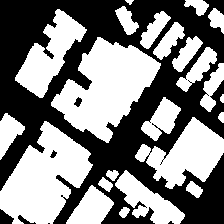

In [43]:
pilmask.show()

In [44]:
#list_np_8band = get_batch_imgs(b=8, lists=[_list_3band, _list_8band], paths=[path_3band, path_8band]).astype(np.float32)

In [45]:
im_4band = np.stack([train_4b_img[2][0,:,:], train_4b_img[2][1,:,:], train_4b_img[2][2,:,:]], axis=0)
im_4band = im_4band.transpose(1,2,0)
im_4band = im_4band / im_4band.max()
im_4band = im_4band*255
print(im_4band.max())

255.0


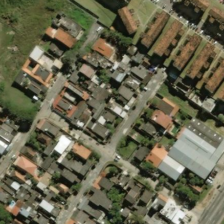

In [46]:
pilimg_4b = Image.fromarray(np.uint8(im_4band))
pilimg_4b.show()

In [47]:
# import gc
# del list_np_8band
# gc.collect()

In [48]:
# list_np_8band_test = get_batch_imgs(b=8, lists=[_list_3band_test, list_8band_test], paths=[path_3band_test, path_8band_test]).astype(np.float32)

In [49]:
# list_np_8band_test.shape

In [50]:
# zero_indices = []  
# for i in range(6940):  
#     if list_np_8band_test[i].max() == 0:  
#         zero_indices.append(i)  
# list_np_8band_test = np.delete(list_np_8band_test, zero_indices, axis=0)  
# list_np_8band_test.shape

omit 8band data because its data size is large

In [51]:
#list_np_8band_test = get_batch_imgs(b=8, lists=[_list_3band_test, _list_8band_test], paths=[path_3band_test, path_8band_test]).astype(np.float32)

In [52]:
def get_augmentation():
    border = cv2.BORDER_CONSTANT
    train_transform = [        
        albu.Blur(),
#         albu.OpticalDistortion(distort_limit=2, border_mode=border),
#         albu.ElasticTransform(alpha=50, border_mode=border),
#         albu.Rotate(limit=15, border_mode=border),
        albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.5, rotate_limit=0, border_mode=border),
#         albu.ShiftScaleRotate(shift_limit=0, scale_limit=0.2, rotate_limit=0, border_mode=border),
        albu.imgaug.transforms.IAAAffine(shear=50, mode='constant'),
        albu.HorizontalFlip(p=1),
        albu.VerticalFlip(p=1),
    ]
    return albu.Compose(train_transform)

transforms = get_augmentation()

train_4b_img_aug = np.zeros(train_4b_img.shape)
train_label_aug = np.zeros(train_label.shape)
for n,(i,j) in tqdm(enumerate(zip(train_4b_img, train_label))):
    augmented = transforms(image=i.transpose(1,2,0), mask=j)
    i,j = augmented['image'], augmented['mask']
    
    train_4b_img_aug[n,:,:,:] = i.transpose(2,0,1)
    train_label_aug[n,:,:] = j


train_4b_img_comp = np.concatenate([train_4b_img, train_4b_img_aug], 0).astype(np.float32)
train_label_comp = np.concatenate([train_label, train_label_aug], 0).astype(np.float32)

3296it [00:10, 299.74it/s]


In [53]:
train_4b_img_comp.shape, train_label_comp.shape

((6592, 4, 224, 224), (6592, 224, 224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


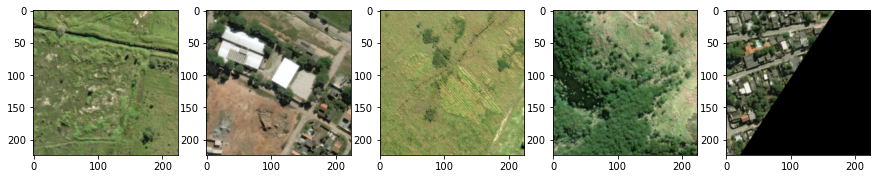

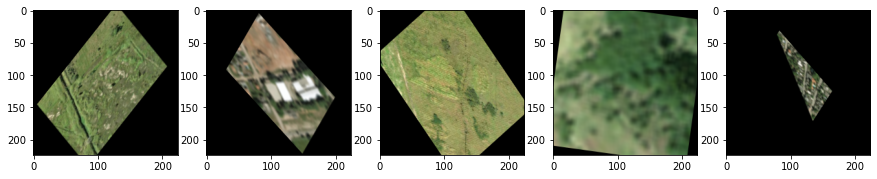

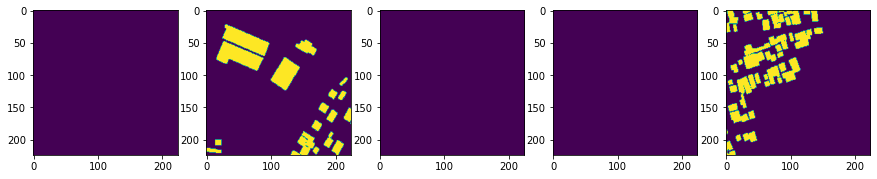

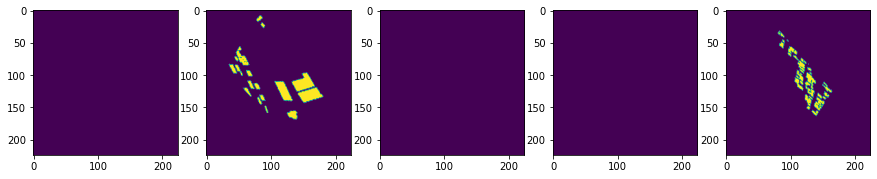

In [54]:
#  plot figures
train_size = train_4b_img.shape[0]
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = np.stack([train_4b_img_comp[150+i][0,:,:], train_4b_img_comp[150+i][1,:,:], train_4b_img_comp[150+i][2,:,:]], axis=0)
    #img = np.stack([train_4b_img[150+i][0,:,:], train_4b_img[150+i][1,:,:], train_4b_img[150+i][2,:,:]], axis=0)
    plt.imshow(img.transpose(1,2,0))
    
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = np.stack([train_4b_img_comp[train_size+150+i][0,:,:], train_4b_img_comp[train_size+150+i][1,:,:], train_4b_img_comp[train_size+150+i][2,:,:]], axis=0)
    plt.imshow(img.transpose(1,2,0)) 
    
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_label[150+i])
    
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_label_comp[train_size+150+i])

In [55]:
# get loader
def get_loader(img, label, batch_size, shuffle):
    x, y = torch.from_numpy(img), torch.from_numpy(label)
    dataset = TensorDataset(x, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset, loader

# 4band
_, train_4b_loader = get_loader(train_4b_img_comp, train_label_comp, 16, True)
#_, train_4b_loader = get_loader(train_4b_img, train_label, 16, True)
_, val_4b_loader = get_loader(val_4b_img, val_label, 1, False)
# test_3b_data, test_3b_loader = get_loader(list_np_3band_test, test_label, 1, False) # -> 後で余ったtrain用データからtestデータを作成

In [56]:
train_4b_img_comp.shape, train_label_comp.shape

((6592, 4, 224, 224), (6592, 224, 224))

In [57]:
train_4b_img.shape, train_label.shape

((3296, 4, 224, 224), (3296, 224, 224))

In [58]:
#  configure
criterion = nn.BCELoss()

#  Metrics
epsilon = 1e-6
def IoU(pred, mask):
    pred = pred.cpu().numpy().astype(int)
    mask = mask.cpu().numpy().astype(int)
    intersection = (pred & mask).sum()
    union = (pred | mask).sum()
    out = (intersection + epsilon) / (union + epsilon)
    return out

In [59]:
# Early stopping
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                #self.counter = 0
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [60]:
# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""

#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)


# class Down(nn.Module):
#     """Downscaling with maxpool then double conv"""

#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             nn.Dropout2d(0.3),
#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)


# class Up(nn.Module):
#     """Upscaling then double conv"""

#     def __init__(self, in_channels, out_channels, bilinear=True):
#         super().__init__()

#         # if bilinear, use the normal convolutions to reduce the number of channels
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
#         else:
#             self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
#             self.conv = DoubleConv(in_channels, out_channels)


#     def forward(self, x1, x2):
#         x1 = self.up(x1)
#         # input is CHW
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
#         # if you have padding issues, see
#         # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
#         # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)


# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)

In [61]:
# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=True):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = DoubleConv(n_channels, 64)
#         self.drop = nn.Dropout2d(0.3)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         factor = 2 if bilinear else 1
#         self.down4 = Down(512, 1024 // factor)
#         self.drop4 = nn.Dropout2d(0.3)
#         self.up1 = Up(1024, 512 // factor, bilinear)
#         self.up2 = Up(512, 256 // factor, bilinear)
#         self.up3 = Up(256, 128 // factor, bilinear)
#         self.up4 = Up(128, 64, bilinear)
#         self.outc = OutConv(64, n_classes)

#     def forward(self, x):
#         x1 = self.inc(x)
#         #x1 = self.drop(x)
#         x2 = self.down1(x1)
#         #x2 = self.drop(x2)
#         x3 = self.down2(x2)
#         #x3 = self.drop(x3)
#         x4 = self.down3(x3)
#         #x4 = self.drop(x4)
#         x5 = self.down4(x4)
#         #x5 = self.drop(x5)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits

In [62]:
#  U-Net Model
#  https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, input_ch, n_class):
        super().__init__()
        
        self.dconv_down1 = double_conv(input_ch, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = double_conv(256+512, 256)
        self.dconv_up2 = double_conv(128+256, 128)
        self.dconv_up1 = double_conv(64+128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

model = UNet(4, 1)
model = model.to(device)  

from torchsummary import summary
summary(model, (4, 224, 224))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           2,368
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [63]:
from torchsummary import summary

In [64]:
model = UNet(4, 1)
model = model.to(device)
summary(model, input_size=(4, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           2,368
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [65]:
#  kfold
fold = KFold(n_splits=3, shuffle=True, random_state=0)
for i,j in(fold.split(train_4b_img, train_label)):
    train_loader = DataLoader(Subset(train_4b_loader, i), shuffle=True, batch_size=16)
    val_loader = DataLoader(Subset(train_4b_loader, j))

In [66]:
#  train 
def train(model, optimizer, train_loader, val_loader, epochs):
    model.train()
    log = {"train_loss":[], "train_iou":[], "val_loss":[], "val_iou":[]}
    early_stopping = EarlyStopping(3, True)
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        epoch_iou = 0
        for data, mask in train_loader:
            data, mask = data.to(device), mask.to(device)
            mask = mask.view(-1)
            out = model(data)
            out = torch.sigmoid(out)
            out = out.view(-1)
            loss = criterion(out, mask)
            pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
            iou = IoU(pred, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss.item())
            epoch_iou += float(iou.item())
        epoch_loss = epoch_loss / len(train_loader)
        epoch_iou = epoch_iou / len(train_loader)
        log["train_loss"].append(epoch_loss)
        log["train_iou"].append(epoch_iou)
        
        # validation
        val_loss = 0
        val_iou = 0
        with torch.no_grad():
            for data, mask in val_loader:
                data, mask = data.to(device), mask.to(device)
                mask = mask.view(-1)
                out = model(data)
                out = torch.sigmoid(out)
                out = out.view(-1)
                loss = criterion(out, mask)
                pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
                iou = IoU(pred, mask)
                val_loss += float(loss.item())
                val_iou += float(iou.item())
        val_loss = val_loss / len(val_loader)
        val_iou = val_iou / len(val_loader)
        log["val_loss"].append(val_loss)
        log["val_iou"].append(val_iou)
        print('epoch{}:終了  train_loss={}, train_iou={}, val_loss={}, val_iou={}\n'.format(epoch, epoch_loss, epoch_iou, val_loss, val_iou))
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(log["train_loss"], color='orangered', label='train')
    plt.plot(log["val_loss"], color='cyan', label='val')
    plt.legend(loc=0)
    
    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('iou')
    plt.plot(log["train_iou"], color='orangered', label='train')
    plt.plot(log["val_iou"], color='cyan', label='val')
    plt.legend(loc=0)
    plt.show()
    fig.savefig("img/train_log.png")
    return log
    
        
#  test
threshold = 0.5
def test(model, load_test):
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.eval()
    test_loss = 0
    test_iou = 0
    for data, mask in tqdm(load_test):
        data, mask = data.to(device), mask.to(device)
        mask = mask.view(-1)
        out = model(data)
        out = torch.sigmoid(out)
        out = out.view(-1)
        loss = criterion(out, mask)
        test_loss += float(loss.item())
        pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
        #pred_np = pred.to('cpu').detach().numpy().copy().reshape(224,224)
        #pred = morphology.binary_closing(pred_np, morphology.diamond(1)).astype(np.uint8)
        #pred = torch.from_numpy(pred).view(-1).to(device)
        iou = IoU(pred, mask)
        test_iou += float(iou.item())
    test_loss = test_loss/len(load_test)
    test_iou = test_iou/len(load_test)
    print('テスト終了  test_loss={},  test_iou={}'.format(test_loss, test_iou))

  3%|▎         | 1/30 [03:45<1:49:04, 225.67s/it]

epoch0:終了  train_loss=0.21254424683894346, train_iou=0.1233289787872854, val_loss=0.18197228006021496, val_iou=0.4325960442882181

Validation loss decreased (inf --> 0.181972).  Saving model ...


  7%|▋         | 2/30 [07:41<1:48:03, 231.57s/it]

epoch1:終了  train_loss=0.16232130213559254, train_iou=0.37114403528986833, val_loss=0.1488385896007911, val_iou=0.5359547014738403

Validation loss decreased (0.181972 --> 0.148839).  Saving model ...


 10%|█         | 3/30 [11:36<1:44:53, 233.11s/it]

epoch2:終了  train_loss=0.14198813147987555, train_iou=0.4755552343311252, val_loss=0.1453221165531736, val_iou=0.5685875173716862

Validation loss decreased (0.148839 --> 0.145322).  Saving model ...


 13%|█▎        | 4/30 [15:31<1:41:23, 233.97s/it]

epoch3:終了  train_loss=0.1332350873379308, train_iou=0.5167953561321665, val_loss=0.1279360589805153, val_iou=0.588885510845209

Validation loss decreased (0.145322 --> 0.127936).  Saving model ...


 17%|█▋        | 5/30 [19:26<1:37:41, 234.46s/it]

epoch4:終了  train_loss=0.12646472641691855, train_iou=0.5430873017834476, val_loss=0.12319311946920639, val_iou=0.6384711695202416

Validation loss decreased (0.127936 --> 0.123193).  Saving model ...


 20%|██        | 6/30 [23:21<1:33:50, 234.61s/it]

epoch5:終了  train_loss=0.12359089985290922, train_iou=0.5552083408780574, val_loss=0.1199710542202029, val_iou=0.6381440688096168

Validation loss decreased (0.123193 --> 0.119971).  Saving model ...


 23%|██▎       | 7/30 [27:16<1:29:56, 234.64s/it]

epoch6:終了  train_loss=0.11943682478469553, train_iou=0.5659052894340939, val_loss=0.11971761560961608, val_iou=0.6445780640640735

Validation loss decreased (0.119971 --> 0.119718).  Saving model ...


 27%|██▋       | 8/30 [31:11<1:26:03, 234.72s/it]

epoch7:終了  train_loss=0.11506897965174856, train_iou=0.579592117189155, val_loss=0.11830515012401331, val_iou=0.6330213796538048

Validation loss decreased (0.119718 --> 0.118305).  Saving model ...


 30%|███       | 9/30 [35:06<1:22:12, 234.86s/it]

epoch8:終了  train_loss=0.11262919984360054, train_iou=0.5874658375863352, val_loss=0.11663593999350653, val_iou=0.6598115323692518

Validation loss decreased (0.118305 --> 0.116636).  Saving model ...


 33%|███▎      | 10/30 [39:01<1:18:19, 234.96s/it]

epoch9:終了  train_loss=0.11248042139685849, train_iou=0.5892624144049871, val_loss=0.11171502886289916, val_iou=0.6798526229047553

Validation loss decreased (0.116636 --> 0.111715).  Saving model ...


 37%|███▋      | 11/30 [42:56<1:14:25, 235.02s/it]

epoch10:終了  train_loss=0.1084225483247739, train_iou=0.6000203864808134, val_loss=0.1077534147644785, val_iou=0.6971880276134929

Validation loss decreased (0.111715 --> 0.107753).  Saving model ...


 40%|████      | 12/30 [46:52<1:10:30, 235.05s/it]

epoch11:終了  train_loss=0.10784078977134043, train_iou=0.6059203128504698, val_loss=0.1123034344997278, val_iou=0.6422508000103962

EarlyStopping counter: 1 out of 3


 43%|████▎     | 13/30 [50:46<1:06:35, 235.01s/it]

epoch12:終了  train_loss=0.10633187805691245, train_iou=0.6095726177172313, val_loss=0.10865036612509767, val_iou=0.6756935086387996

EarlyStopping counter: 2 out of 3


 47%|████▋     | 14/30 [54:42<1:02:40, 235.02s/it]

epoch13:終了  train_loss=0.10299841137331667, train_iou=0.6175666362376723, val_loss=0.10691184058392263, val_iou=0.6826150903034487

Validation loss decreased (0.107753 --> 0.106912).  Saving model ...


 50%|█████     | 15/30 [58:37<58:45, 235.03s/it]  

epoch14:終了  train_loss=0.10056632427607202, train_iou=0.6274283268460665, val_loss=0.12161462928494837, val_iou=0.6434657228896341

EarlyStopping counter: 1 out of 3


 53%|█████▎    | 16/30 [1:02:32<54:51, 235.11s/it]

epoch15:終了  train_loss=0.10460667117290849, train_iou=0.6126397421780886, val_loss=0.10533117255919408, val_iou=0.711219317780614

Validation loss decreased (0.106912 --> 0.105331).  Saving model ...


 57%|█████▋    | 17/30 [1:06:27<50:56, 235.09s/it]

epoch16:終了  train_loss=0.09878342877621356, train_iou=0.6320474210602431, val_loss=0.11491594860978495, val_iou=0.6524284011691348

EarlyStopping counter: 1 out of 3


 60%|██████    | 18/30 [1:10:22<47:00, 235.07s/it]

epoch17:終了  train_loss=0.0983946584752824, train_iou=0.63398447983346, val_loss=0.10547325962287446, val_iou=0.6657321455689794

EarlyStopping counter: 2 out of 3


 60%|██████    | 18/30 [1:14:17<49:31, 247.64s/it]

epoch18:終了  train_loss=0.10111109065163193, train_iou=0.6229747725693987, val_loss=0.10758684829679202, val_iou=0.6993022442881396

EarlyStopping counter: 3 out of 3
Early stopping


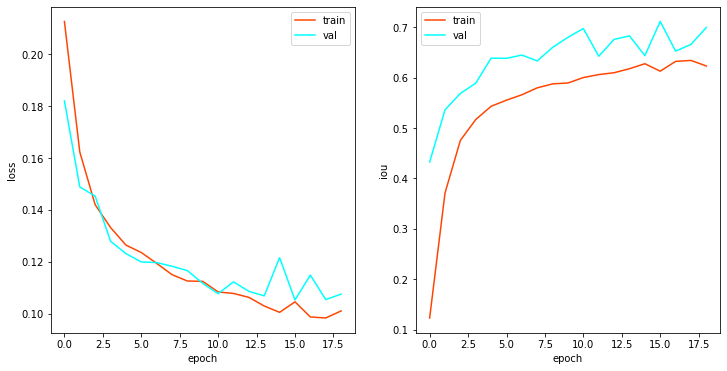

FileNotFoundError: [Errno 2] No such file or directory: 'img/train_log.png'

In [67]:
#  execute train
model = UNet(4, 1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
log = {"train_loss":[], "train_iou":[], "val_loss":[], "val_iou":[]} 
log = train(model, optimizer, train_4b_loader, val_4b_loader, 30)

In [68]:
_list_3band_others = [f for f in list_3band if not f in _list_3band]
_list_8band_others = [f for f in list_8band if not f in _list_8band]
# len(_list_8band_others)
_list_3band_others = _list_3band_others[50:50+5]
_list_8band_others = _list_8band_others[50:50+5]

#list_np_8band_others = get_batch_imgs(b=8, lists=[_list_3band, _list_8band_others], paths=[path_3band, path_8band]).astype(np.float32)

test_4band_img = get_batch_imgs(b=4, lists=[_list_3band_others, _list_8band_others], paths=[path_3band, path_8band]).astype(np.float32)
zero_indices = []  
for i in range(N):  
    if test_4band_img[i].max() == 0:  
        zero_indices.append(i)  
test_4band_img = np.delete(test_4band_img, zero_indices, axis=0)  

_list_label_others = [f for f in list_masks if not f in _list_masks]
_list_label_others = _list_label_others[50:50+5]

test_label = np.zeros((5, s, s))
path = path_mask_img
for i, img in tqdm(enumerate(resize_images(_list_label_others, path))):
    test_label[i,:,:] = img

5it [00:00, 17.35it/s]
5it [00:00, 765.86it/s]
100%|██████████| 5/5 [00:00<00:00, 64.69it/s]
5it [00:00, 4203.55it/s]


In [69]:
test_np_4band_img = np.array(test_4band_img).astype(np.float32)
test_np_label = np.array(test_label).astype(np.float32)

In [70]:
test_np_4band_img.shape

(5, 4, 224, 224)

In [71]:
test_4b_data, test_4b_loader = get_loader(test_np_4band_img, test_np_label, 1, False)

In [72]:
model.to(device)
test(model, test_4b_loader)

100%|██████████| 5/5 [00:00<00:00, 70.78it/s]

テスト終了  test_loss=0.11510391832121059,  test_iou=0.8621036866529966


In [73]:
test_np_4band_img.shape

(5, 4, 224, 224)

In [74]:
def plot_result(result_model, dataset, id=0):
    fig = plt.figure(figsize=(20,12))
    for i in range(5):
        img, mask = dataset[id+i]
        print(type(img))
        pred = result_model(img.unsqueeze(0).to(device))
        pred = pred.cpu().detach().numpy().squeeze()
        pred = np.where(pred>=0.5, 1, 0)
        #pred = morphology.binary_opening(pred, morphology.diamond(1)).astype(np.uint8)
        img = img.numpy().transpose(1,2,0)
        mask = mask.numpy()
        plt.subplot(3,5,i+1)
        plt.title('Image')
        img = np.stack([img[:,:,0], img[:,:,1], img[:,:,2]], axis=2)
        plt.imshow(img)
        plt.subplot(3,5,i+6)
        plt.title('Predict')
        plt.imshow(pred)
        plt.subplot(3,5,i+11)
        plt.title('Truth')
        plt.imshow(mask)
    #fig.savefig("img/pred.png")

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


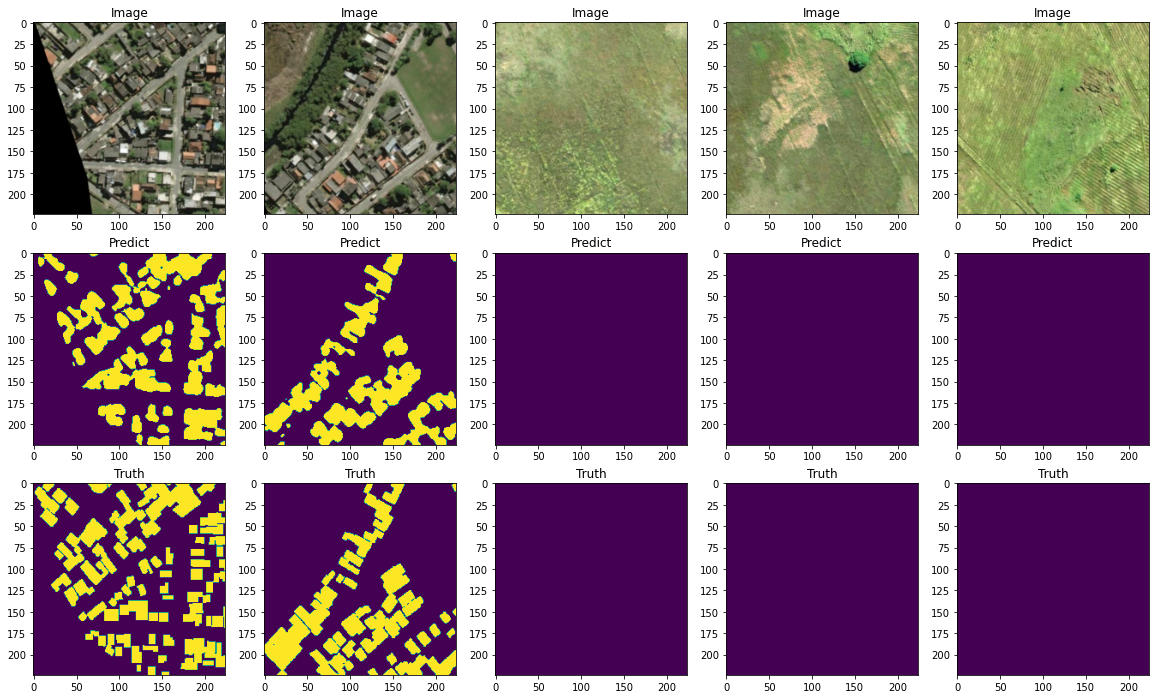

In [75]:
plot_result(model, test_4b_data)

# Masuda urban areas

In [76]:
image1 = '../building_detection_data/masuda_sat_imgs/PHR1B_acq20201112_Masuda_Urban.TIF'
image2 = '../building_detection_data/masuda_sat_imgs/PHR1B_acq20210315_Masuda_Urban.TIF'

psh1 = rio.open(image1)
psh1_meta = psh1.meta
psh1 = psh1.read().transpose([1,2,0]).astype('float')

psh2 = rio.open(image2)
psh2_meta = psh2.meta
psh2 = psh2.read().transpose([1,2,0]).astype('float')

In [ ]:
psh1.shape

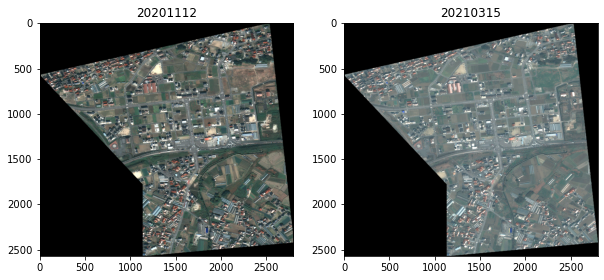

In [77]:
# Image check
import utils
def stack_3band(img, i=1, j=2, k=4, gray=False):
    '''
    False color visuliazation
    [1,2,4] - RGB
    [7,3,1] - cement
    '''
    img_3band = np.stack([img[:, :, i],
                         img[:, :, j],
                         img[:, :, k]], axis=2)
    img_gray = (img[:, :, i] + img[:, :, j] + img[:, :, k]) / 3
    if gray:
        return img_gray[:, :, np.newaxis].astype('int32')
    else:
        return img_3band

psh_rgb1 = stack_3band(psh1, 0,1,2)
psh_rgb2 = stack_3band(psh2, 0,1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(utils.scale_percentile(psh_rgb1))
ax1.set_title('20201112')
ax2.set_title('20210315')
ax2.imshow(utils.scale_percentile(psh_rgb2))

In [ ]:
psh_rgb1.shape

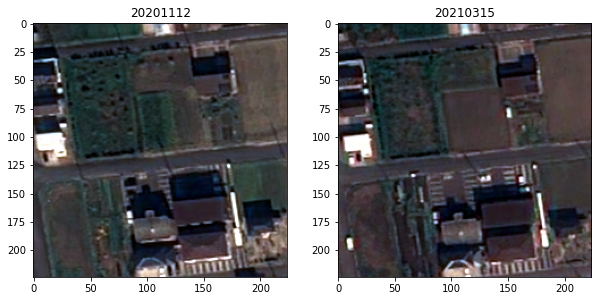

In [78]:
_psh_rgb1 = psh_rgb1[1000:1000+224, 1000:1000+224]
_psh_rgb2 = psh_rgb2[1000:1000+224, 1000:1000+224]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(utils.scale_percentile(_psh_rgb1))
ax1.set_title('20201112')
ax2.set_title('20210315')
ax2.imshow(utils.scale_percentile(_psh_rgb2))

In [79]:
_psh1 = psh1[1000:1000+224, 1000:1000+224, :]
# _psh1 = psh1[1000:1000+448, 1000:1000+448, :]
# img = Image.fromarray(np.uint8(_psh1))
# _psh1 = np.asarray(img.resize((224,224)))

_psh1.shape

(224, 224, 4)

In [80]:
#_psh1 = np.array(_psh1)
_psh1 = _psh1.transpose(2,0,1)
_psh1 = _psh1[np.newaxis,:,:,:]

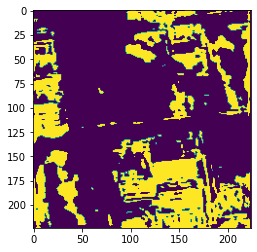

In [81]:
pred = model(torch.from_numpy(_psh1.astype(np.float32)).to(device))
pred = pred.cpu().detach().numpy().squeeze()
pred = np.where(pred>=0.5, 1, 0)
plt.imshow(pred)

In [ ]:
type(_psh1)